In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
import seaborn as sns
from thesispy.definitions import ROOT_DIR, INSTANCES_SRC

In [2]:
from argparse import ArgumentError


def generate_sphere(x, y, z, radius, center):
    return (x - center[0] + 0.5)**2 + (y - center[1] + 0.5)**2 + (z - center[2] + 0.5)**2 < radius**2

def generate_cube(dims, low, high, val=100):
    cube = np.zeros(dims)
    cube[low:high, low:high, low:high] = val
    return cube    

def map_sphere(p, radius, center, new_radius):
    p = np.array(p)
    center = np.array(center)
    if np.all(p == center):
        return p
    
    radius += 0.5
    p = (p - center) / radius
    p = p * new_radius
    return p + center

def calc_prob_1d_gaussian(x, mean, var):
    return np.exp(-0.5 * (x - mean)**2 / var) / np.sqrt(2 * np.pi * var)

def map_fixed_point_using_spheres(p, center, r_sphere_m, r_sq):
    p = np.array(p)
    center = np.array(center)
    p_norm = p - center

    p_sq_sphere = (r_sq-0.5) / np.linalg.norm(p_norm) * p_norm + center
    p_sphere_m = (r_sphere_m+0.5) / np.linalg.norm(p_norm) * p_norm + center
    d1 = np.linalg.norm(p_norm)
    d2 = np.linalg.norm(p_sq_sphere - center)
    if d1 >= d2:
        return p
    else: 
        return p_sphere_m + (d1/d2)**2 * (p_sq_sphere - p_sphere_m)

def map_fixed_point_using_sq(p, center, r_sphere_m, r_sq):
    p = np.array(p)
    center = np.array(center)
    p_norm = p - center
    u = np.max(np.abs(p_norm))

    p_sq = (r_sq-0.5) * (p_norm/u) + center
    p_sphere_m = (r_sphere_m + 0.5) / np.linalg.norm(p_norm) * p_norm + center
    d1 = np.linalg.norm(p_norm)
    d2 = np.linalg.norm(p_sq - center)
    return p_sphere_m + (d1/d2)**3 * (p_sq - p_sphere_m)

def generate_synthetic_01(version=2):
    fixed = generate_cube((30, 30, 30), 5, 25)
    fixed_sphere = generate_sphere(*np.indices(fixed.shape), 5, (15, 15, 15))
    fixed[fixed_sphere > 0] = 200

    moving = generate_cube((30, 30, 30), 5, 25)
    moving_sphere = generate_sphere(*np.indices(moving.shape), 8, (15, 15, 15))
    moving[moving_sphere > 0] = 200

    dvf = np.zeros((30, 30, 30, 3), dtype=np.float32)
    for p in np.ndindex((30, 30, 30)):
        p_pixel = np.array(p) + 0.5
        if fixed_sphere[p] > 0:
            dvf[p] = map_sphere(p_pixel, 5, (15, 15, 15), 8) - p_pixel

        elif fixed[p] > 0:
            match version:
                case 1:
                    dvf[p] = map_fixed_point_using_spheres(p_pixel, (15,15,15), 8, 10) - p_pixel
                case 2:
                    dvf[p] = map_fixed_point_using_sq(p_pixel, (15,15,15), 8, 10) - p_pixel
                case _:
                    raise Exception(f"Invalid version number: {version}")
        
    return fixed, moving, dvf

In [9]:
def get_img_data(path: Path):
    image = sitk.ReadImage(str(path.resolve()))
    data = sitk.GetArrayFromImage(image)
    if len(data.shape) == 4 or (len(data.shape) == 3 and data.shape[-1] > 2):
        data = np.swapaxes(data, 0, 2)
    else:
        data = np.swapaxes(data, 0, 1)

    return data

def get_cmap_color(cmap, f, a):
    c = cmap(f)
    c[..., 3] = a
    return c

def plot_voxels(data, lms=None, y_slice_depth = 15, orientation=(0, -70), cmap_name='Greys', alpha=1.0):
    ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
    sliced_data = np.copy(data)
    sliced_data[:, :y_slice_depth, :] = 0
    # sliced_data[sliced_data < 10] = 0
    
    cmap = cm.get_cmap(cmap_name)
    norm = Normalize(vmin=np.min(sliced_data), vmax=1.5*np.max(sliced_data))

    colors = np.array(list(map(lambda x: get_cmap_color(cmap, norm(x), alpha), sliced_data)))

    ax.voxels(sliced_data, facecolors=colors, edgecolor=(0, 0, 0, 0.2))
    ax.set_xlim3d(1, 29)
    ax.set_ylim3d(5, 29)
    ax.set_zlim3d(1, 29)
    ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())))
    plt.locator_params(axis='y', nbins=3)
    ax.view_init(*orientation)

    if lms is not None:
        for lm in lms:
            if abs(lm[1] - y_slice_depth) <= 0.25:
                ax.scatter(lm[0], lm[1], lm[2], s=50, c='r')

def plot_dvf(data, scale=1.0, invert=False, slice=None):
    if len(data.shape[:-1]) > 2:
        if slice is None:
            slice = data.shape[0] // 2
        data = data[:,:,slice,:]
    
    X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
    if invert:
        X = X + data[..., 1]
        Y = Y + data[..., 0]
        data = -data

    X = X + 0.5
    Y = Y + 0.5

    u = data[:,:,0]
    v = data[:,:,1]
    c = np.sqrt(u**2 + v**2)
    
    fig, ax = plt.subplots(figsize =(7, 7))
    qq = ax.quiver(X, Y, v, u, c, scale=scale, units='xy', angles='xy', scale_units='xy', cmap=plt.cm.jet)

    ax.set_xticks([i for i in range(data.shape[0])][::2])
    ax.set_yticks([i for i in range(data.shape[1])][::2])
    ax.set_xlim(0, data.shape[0])
    ax.set_ylim(0, data.shape[1])
    ax.grid(True)
    ax.set_aspect('equal')
    fig.colorbar(qq,fraction=0.045, pad=0.02, label='Displacement magnitude')

def read_controlpoints(path: Path):
    with open(path) as file:
        lines = file.readlines()
        dim = len(lines[0].split()) // 2
        grid_size = lines[-1].split()[:dim]
        grid = np.zeros(tuple([int(grid_size[i]) + 1 for i in range(dim)] + [dim]))
        for line in lines:
            s = line.split()
            index = np.array(s[:dim], dtype=int)
            point = np.array(s[dim:], dtype=float)
            grid[tuple(index)] = point
        return grid

def plot_cpoints(points, grid_spacing, grid_origin, slice=None):
    points_slice = points
    if len(points.shape) == 4:
        if slice is None:
            slice = points.shape[2] // 2
        points_slice = points[:, :, slice, :]

    grid_spacing = np.array(grid_spacing)
    grid_origin = np.array(grid_origin)

    grid_origin = grid_origin + 0.5
    X, Y = np.meshgrid(
        *[
            np.arange(grid_origin[i], grid_origin[i] + grid_spacing[i] * points_slice.shape[i], grid_spacing[i])
            for i in range(len(points_slice.shape[:-1]))
        ]
    )

    colors = np.zeros(points_slice.shape[:-1])
    x_slice = colors.shape[0] // 2
    y_slice = colors.shape[1] // 2
    colors[:x_slice, :y_slice] = 0.25
    colors[x_slice:, :y_slice] = 0.5
    colors[:x_slice, y_slice:] = 0.75
    colors[x_slice:, y_slice:] = 1.0
            
    colormap_colors = ['#ffcc00', 'red', 'green', 'blue']
    cmap = LinearSegmentedColormap.from_list('quadrants', colormap_colors)

    _, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(Y, X, marker="+", c=colors, cmap=cmap, alpha=0.3, s=20)
    ax.scatter(points_slice[..., 0], points_slice[..., 1], marker="s", s=15, c=colors, cmap=cmap, alpha=0.8)

In [10]:
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.spatial import distance
from skimage import data
from skimage.filters import threshold_multiotsu

class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

def hessian(dvf_slice, p):
  p = np.array(p, dtype=int)
  try:
    dvf_slice[tuple(p)]
  except IndexError:
    print(f"Point {p} is out of bounds")
    return None

  n = len(p)
  output = np.matrix(np.zeros(n*n))
  output = output.reshape(n,n)
  max_indices = np.array(dvf_slice.shape) - 1
  ei = np.zeros(n, dtype=int)
  ej = np.zeros(n, dtype=int)
  
  for i in range(n):
    for j in range(i+1):
      ei[i] = 1
      ej[j] = 1
      f1 = dvf_slice[tuple((np.clip(p + ei + ej, 0, max_indices)))]
      f2 = dvf_slice[tuple((np.clip(p + ei - ej, 0, max_indices)))]
      f3 = dvf_slice[tuple((np.clip(p - ei + ej, 0, max_indices)))]
      f4 = dvf_slice[tuple((np.clip(p - ei - ej, 0, max_indices)))]
      numdiff = (f1-f2-f3+f4)/4     
      output[i,j] = numdiff
      output[j,i] = numdiff
      ei[i] = 0
      ej[j] = 0
  return output

def bending_energy_point(dvf, p):
  sum = 0.0
  for dim in range(len(dvf.shape)-1):
    sum += np.square(np.linalg.norm(hessian(dvf[..., dim], p)))
  return sum

def bending_energy(dvf):
  results = ProgressParallel(n_jobs=16, total=np.prod(dvf.shape[:-1]))(delayed(bending_energy_point)(dvf, p) for p in np.ndindex(dvf.shape[:-1]))

  return np.sum(results) / np.prod(dvf.shape[:-1])

def dice_similarity(moving_deformed, fixed, levels):
  thresholds_moving = threshold_multiotsu(moving_deformed, classes=levels)
  thresholds_fixed = threshold_multiotsu(fixed, classes=levels)
  regions_moving_deformed = np.digitize(moving_deformed, bins=thresholds_moving)
  regions_fixed = np.digitize(fixed, bins=thresholds_fixed)

  intersection = np.sum((regions_moving_deformed == regions_fixed) & (regions_fixed > 0))
  union = np.sum(regions_moving_deformed > 0 ) + np.sum(regions_fixed > 0)
  return 2.0 * intersection / union

def hausdorff_distance(lms1, lms2, spacing=1):
    return np.max(distance.cdist(lms1, lms2).min(axis=1))

def dvf_rmse(dvf1, dvf2, spacing=1):
    return np.linalg.norm((dvf1 - dvf2) * spacing, axis=3).mean()

def mean_surface_distance(lms1, lms2, spacing=1):
    return np.mean(distance.cdist(lms1, lms2).min(axis=1) * spacing)

def jacobian_determinant(dvf):
  axis_swap = 2 if len(dvf.shape) == 4 else 1
  dvf = np.swapaxes(dvf, 0, axis_swap)
  dvf_img = sitk.GetImageFromArray(dvf, isVector=True)
  jac_det_contracting_field = sitk.DisplacementFieldJacobianDeterminant(dvf_img)
  contracting_arr = sitk.GetArrayFromImage(jac_det_contracting_field)
  contracting_arr = np.swapaxes(contracting_arr, 0, axis_swap)
  return contracting_arr


In [11]:
fixed, moving, dvf = generate_synthetic_01()

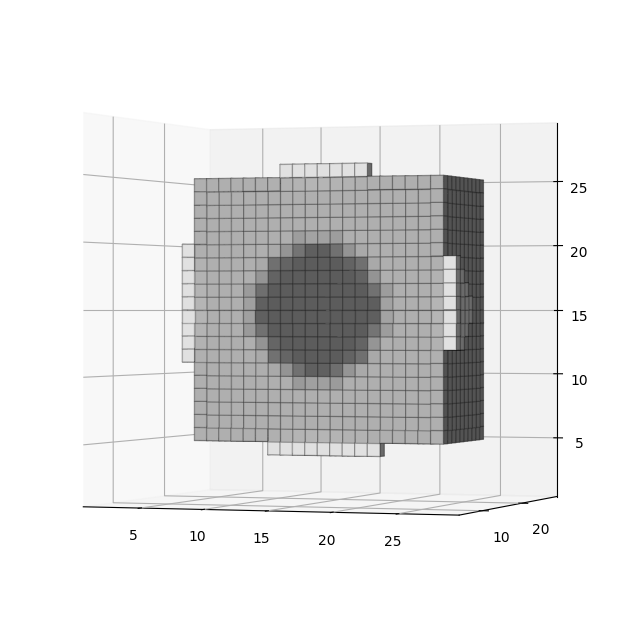

In [33]:
dvf_img = sitk.ReadImage("deformationField.mhd", sitk.sitkVectorFloat64)
reference_image = sitk.ReadImage(INSTANCES_SRC / 'synthetic' / 'scans' / '01_Fixed.mhd')
moving_image = sitk.ReadImage(INSTANCES_SRC / 'synthetic' / 'scans' / '01_Moving.mhd')
displacement_transform = sitk.DisplacementFieldTransform(dvf_img)
moving_deformed = sitk.Resample(moving_image, moving_image, displacement_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
deformed = sitk.GetArrayFromImage(moving_deformed)
deformed = np.swapaxes(deformed, 0, 2)
plot_voxels(deformed)

<AxesSubplot:>

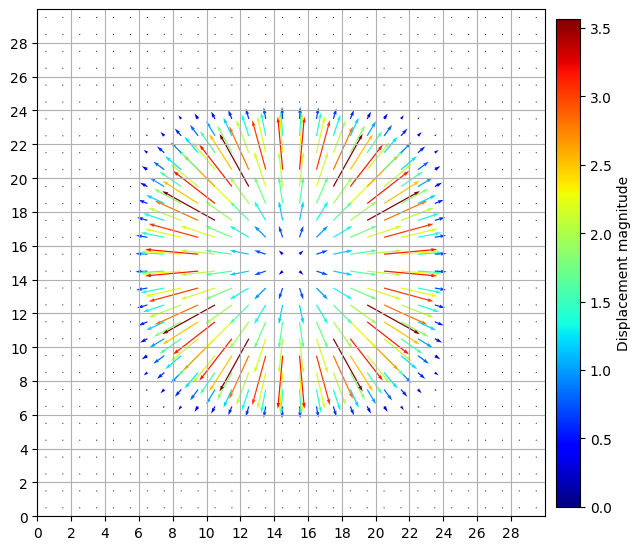

In [317]:
plot_dvf(dvf)

In [303]:
dvf_rmse(dvf, np.zeros_like(dvf))

0.24881046

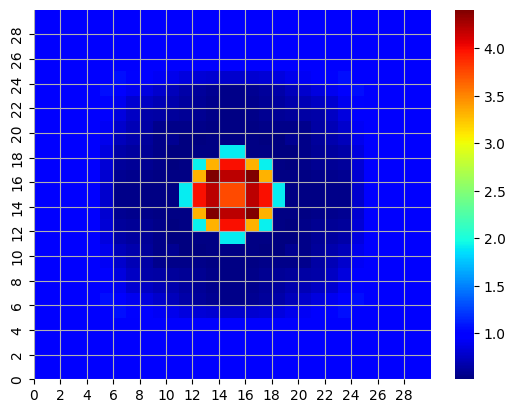

In [304]:
jac_det = jacobian_determinant(dvf)
sns.heatmap(jac_det[..., 10], cmap='jet')
plt.gca().invert_yaxis()
plt.gca().set_xticks([i for i in range(jac_det.shape[0])][::2], labels=[i for i in range(jac_det.shape[0])][::2])
plt.gca().set_yticks([i for i in range(jac_det.shape[1])][::2], labels=[i for i in range(jac_det.shape[1])][::2])
plt.gca().grid(True)

In [305]:
np.min(jac_det), np.max(jac_det)

(0.28290036, 4.978526)

In [314]:
reference_image = sitk.ReadImage(INSTANCES_SRC / 'synthetic' / 'scans' / '01_Fixed.mhd')
moving_image = sitk.ReadImage(INSTANCES_SRC / 'synthetic' / 'scans' / '01_Moving.mhd')
dvf_img = sitk.GetImageFromArray(np.swapaxes(dvf, 0, 2).astype(np.float64), isVector=True)
displacement_transform = sitk.DisplacementFieldTransform(dvf_img)
moving_deformed = sitk.Resample(moving_image, reference_image, displacement_transform, sitk.sitkNearestNeighbor, 0.0, moving_image.GetPixelID())
deformed = sitk.GetArrayFromImage(moving_deformed)
deformed = np.swapaxes(deformed, 0, 2)
sitk.WriteImage(moving_deformed, INSTANCES_SRC / 'synthetic' / 'scans' / '01_Fixed.mhd')

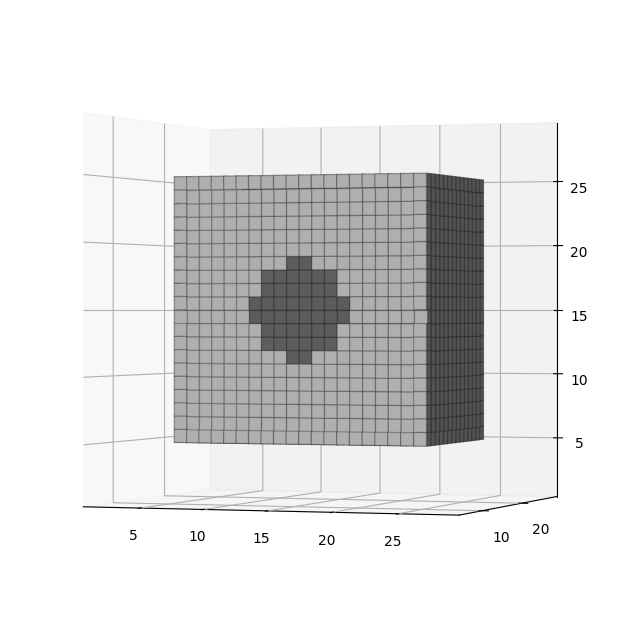

In [310]:
plot_voxels(deformed, y_slice_depth=11)

In [313]:
for p in np.argwhere(deformed != fixed):
    print(deformed[tuple(p)] - fixed[tuple(p)])
print(np.sum(deformed != fixed))

0


In [230]:
np.prod(deformed.shape)

27000

In [198]:
# # Bending energy calculation using interpolation

# from joblib import Parallel, delayed
# import numdifftools as nd
# from interp3d import interp_3d
# from tqdm import tqdm

# def get_hessians_numdiff(dvf):
#   hessians = []
#   for dim in range(len(dvf.shape)-1):
#       dvf_slice = dvf[..., dim]
#       max_indices = np.array(dvf_slice.shape) - 1
#       dvf_mapping = lambda x: dvf_slice[tuple(np.clip(x.astype(int), 0, max_indices))]
#       hessian = nd.Hessian(dvf_mapping, step=1)
#       hessians.append(hessian)
#   return hessians

# def bending_energy_numdiff(dvf):
#   sum = 0.0
#   hessians = get_hessians_numdiff(dvf)
#   for p in np.ndindex(dvf.shape[:-1]):
#     for dim in range(len(dvf.shape)-1):
#       sum += np.square(np.linalg.norm(hessians[dim](p)))
#   return sum / np.prod(dvf.shape[:-1])

# def hessian(grid_interpolator, p, delta):
#   p = np.array(p)
#   try:
#     grid_interpolator(p)
#   except ValueError:
#     print(f"Point {p} is out of bounds")
#     return None

#   n = len(p)
#   output = np.matrix(np.zeros(n*n))
#   output = output.reshape(n,n)
#   max_indices = [grid_interpolator.max_x, grid_interpolator.max_y, grid_interpolator.max_z]
  
#   for i in range(n):
#     for j in range(i+1):
#       ei = np.zeros(n)
#       ei[i] = 1
#       ej = np.zeros(n)
#       ej[j] = 1
#       f1 = grid_interpolator(np.clip(p + delta * ei + delta * ej, 0, max_indices))
#       f2 = grid_interpolator(np.clip(p + delta * ei - delta * ej, 0, max_indices))
#       f3 = grid_interpolator(np.clip(p - delta * ei + delta * ej, 0, max_indices))
#       f4 = grid_interpolator(np.clip(p - delta * ei - delta * ej, 0, max_indices))
#       numdiff = (f1-f2-f3+f4)/(4*delta*delta)
#       output[i,j] = numdiff
#       output[j,i] = numdiff
#   return output

# def bending_energy_point(interpolator, p, delta):
#   return np.square(np.linalg.norm(hessian(interpolator, p, delta)))

# def bending_energy(dvf, delta=0.333):
#   n = np.prod(dvf.shape[:-1])

#   x = np.arange(dvf.shape[0])
#   y = np.arange(dvf.shape[1])
#   z = np.arange(dvf.shape[2])
#   sum = 0.0

#   for dim in range(len(dvf.shape)-1):
#     dvf_slice = np.copy(dvf[..., dim], order='C').astype(np.float64)
#     fn = interp_3d.Interp3D(dvf_slice, x,y,z)
#     results = ProgressParallel(n_jobs=16, total=n)(delayed(bending_energy_point)(fn, p, delta) for p in np.ndindex(dvf.shape[:-1]))
#     sum += np.sum(results)

#   return sum / np.prod(dvf.shape[:-1])